In [11]:
import cv2
import numpy as np 
import pickle
import img_xtend
from img_xtend.detection.bbox import Bbox

with open('/home/nvidia/dev/img_new/scripts/keypoints.pkl', 'rb') as f:
    pose_result = pickle.load(f)

In [19]:
keypoints_xy = pose_result.keypoints.xy

In [20]:
a = {'posn': [366, 159, 252, 219]}

In [22]:
face = np.load('face_crop.npy')

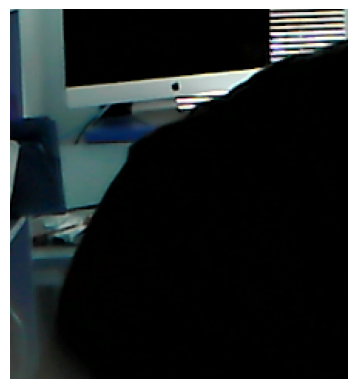

In [24]:
import matplotlib.pyplot as plt
plt.imshow(face)
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()
